<a href="https://colab.research.google.com/github/abhijith789/Brain-tumor-classification-using-CNN/blob/main/Brain_Tumor_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About the Dataset**

This dataset is a compilation of three primary datasets: figshare, Br35H, and a removed source due to bad data. The dataset comprises a total of 7023 human brain MRI images, categorized into four distinct classes. The dataset focuses on brain tumors and their classification. The four classes are as follows:

- **Glioma:** Cancerous brain tumors in glial cells.

- **Meningioma:** Non-cancerous tumors originating from the meninges.
- **No Tumor:** Normal brain scans without detectable tumors.

- **Pituitary:** Tumors affecting the pituitary gland, which can be cancerous or non-cancerous.

Advancing the development of machine learning models for tumor classification is crucial for driving progress in the field of neurology and making a significant impact on the lives of individuals. These models have the potential to enhance medical research, improve diagnostic accuracy, and contribute to effective treatment strategies for various types of tumors. By leveraging machine learning techniques, we can significantly aid in the advancement of neurology and ultimately improve healthcare outcomes for people affected by tumors.

The "No Tumor" class images were obtained from the Br35H dataset

In [41]:
import json
import seaborn as sns
import numpy as np
import cv2
import os
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D

In [42]:
!pip install kaggle

In [3]:
kaggle_credentials = json.load(open('/content/kaggle.json'))

In [4]:
# Setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [5]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:01<00:00, 160MB/s]
100% 149M/149M [00:01<00:00, 139MB/s]


In [6]:
with ZipFile('/content/brain-tumor-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
!ls

brain-tumor-mri-dataset.zip  kaggle.json  sample_data  Testing	Training


# **1. Read & Understand the file**

In [8]:
os.listdir('/content/Training')
os.listdir('/content/Testing')

['pituitary', 'glioma', 'meningioma', 'notumor']

 **Checking the class distribution from Training**

In [9]:
train_distribution = {}
labels = ['glioma', 'pituitary', 'meningioma', 'notumor']
print("Training data Class distribution\n", "-"* 30)
for label in labels:
  print(f'Size of class {label} : {len(os.listdir("/content/Training/"+label))}')
  train_distribution[label] = len(os.listdir("/content/Training/"+label))


Training data Class distribution
 ------------------------------
Size of class glioma : 1321
Size of class pituitary : 1457
Size of class meningioma : 1339
Size of class notumor : 1595


**Checking the class distribution from Training**

In [10]:
test_distribution = {}
print("Testing data Class distribution\n","-"* 30)
for label in labels:
  print(f'Size of class {label} : {len(os.listdir("/content/Testing/"+label))}')
  test_distribution[label] = len(os.listdir("/content/Testing/"+label))

Testing data Class distribution
 ------------------------------
Size of class glioma : 300
Size of class pituitary : 300
Size of class meningioma : 306
Size of class notumor : 405


In [11]:
train_size = len(os.listdir('/content/Training/glioma')) + len(os.listdir('/content/Training/pituitary')) + len(os.listdir('/content/Training/meningioma')) + len(os.listdir('/content/Training/notumor'))
test_size = len(os.listdir('/content/Testing/glioma')) + len(os.listdir('/content/Testing/pituitary')) + len(os.listdir('/content/Testing/meningioma')) + len(os.listdir('/content/Testing/notumor'))
print(f'Train size : {train_size}')
print(f'Test size : {test_size}')

Train size : 5712
Test size : 1311


# **Plotting the Distribution of classes**

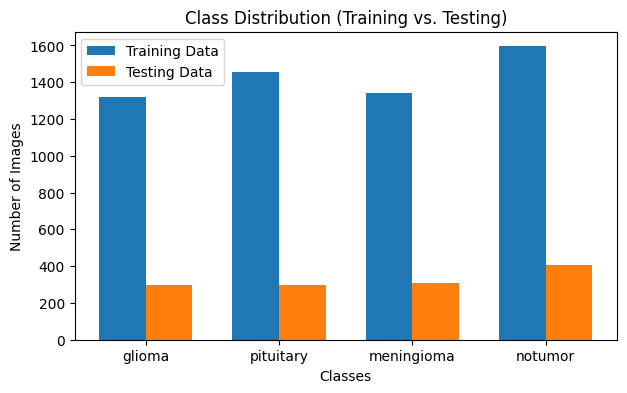

In [12]:
def plot_class_distribution(train_distribution, test_distribution, labels):

  x = range(len(labels))
  width = 0.35
  plt.figure(figsize=(7, 4))
  plt.bar(x, list(train_distribution.values()), width, label='Training Data')
  plt.bar([i + width for i in x], list(test_distribution.values()), width, label='Testing Data')
  plt.xticks([i + width/2 for i in x], labels)
  plt.xlabel('Classes')
  plt.ylabel('Number of Images')
  plt.title('Class Distribution (Training vs. Testing)')
  plt.legend()
  plt.show()

plot_class_distribution(train_distribution, test_distribution, labels)

# **Insight : The classes are having uneven distribution**

# **Display image samples from each class**

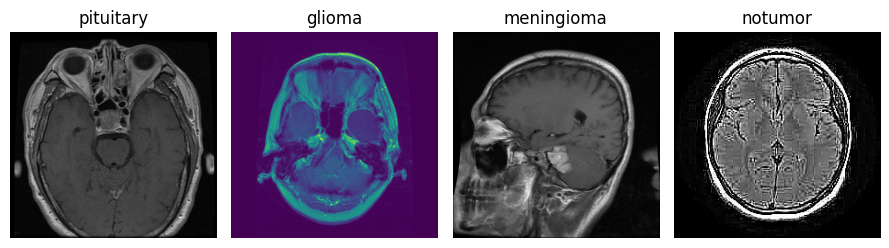

In [13]:
def display_one_image_per_class(data_dir):

  class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
  fig, axes = plt.subplots(1, len(class_dirs), figsize=(9, 4))

  for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(data_dir, class_dir)
    image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg')]
    image_path = image_paths[0]
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_dir)
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

data_dir = '/content/Training'
display_one_image_per_class(data_dir)

# **Chech the extension of images**

In [14]:
def check_image_extensions(data_dir, labels):

  extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

  for label in labels:
    label_dir = os.path.join(data_dir, label)
    print(f"Checking extensions for label: {label}")

    extensions_found = set()
    for filename in os.listdir(label_dir):
      _, ext = os.path.splitext(filename)
      if ext.lower() not in extensions:
        print(f"  Unsupported extension: {ext} in file: {filename}")
      else:
        extensions_found.add(ext.lower())

    if len(extensions_found) == 1:
      print(f"  All images in '{label}' have the same extension: {list(extensions_found)[0]}")
    elif len(extensions_found) > 1:
      print(f"  Multiple extensions found in '{label}': {extensions_found}")
    else:
      print(f"  No images found in '{label}'")

check_image_extensions(data_dir, labels)

Checking extensions for label: glioma
  All images in 'glioma' have the same extension: .jpg
Checking extensions for label: pituitary
  All images in 'pituitary' have the same extension: .jpg
Checking extensions for label: meningioma
  All images in 'meningioma' have the same extension: .jpg
Checking extensions for label: notumor
  All images in 'notumor' have the same extension: .jpg


# **Check the image size/shape**

In [15]:
def check_image_sizes(data_dir, labels):

  for label in labels:
    label_dir = os.path.join(data_dir, label)
    print(f"Checking image sizes for Class: {label}")

    image_paths = [os.path.join(label_dir, filename)
                   for filename in os.listdir(label_dir)
                   if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

    if not image_paths:
      print(f"  No images found in '{label}'.")
      continue

    first_image_path = image_paths[0]
    img = cv2.imread(first_image_path)
    if img is None:
      print(f"  Error loading image: {first_image_path}")
      continue
    first_image_shape = img.shape[:2]  # Get height and width

    for path in image_paths[1:]:
      img = cv2.imread(path)
      if img is None:
        print(f"  Error loading image: {path}")
        continue
      if img.shape[:2] != first_image_shape:
        print(f"  Images in '{label}' have different dimensions.\n","-"*40)
        break
    else:
      print(f"  All images in '{label}' have the same dimensions: {first_image_shape}.\n","-"*50)


check_image_sizes(data_dir, labels)

Checking image sizes for Class: glioma
  All images in 'glioma' have the same dimensions: (512, 512).
 --------------------------------------------------
Checking image sizes for Class: pituitary
  Images in 'pituitary' have different dimensions.
 ----------------------------------------
Checking image sizes for Class: meningioma
  Images in 'meningioma' have different dimensions.
 ----------------------------------------
Checking image sizes for Class: notumor
  Images in 'notumor' have different dimensions.
 ----------------------------------------


# **Insights:**
- Four classes found
- Found class imbalance in both Testing and Training folder
- Images are of same extension (.jpg)
- Images have different dimensions and color channel

# **2. Preprocess**

In [16]:
train_dir = '/content/Training'
test_dir = '/content/Testing'

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip = True)
train_set = train_datagen.flow_from_directory(train_dir,target_size = (224,224),batch_size = 32,class_mode = 'categorical')

test_datagen = ImageDataGenerator(horizontal_flip = True)
test_set = test_datagen.flow_from_directory(test_dir, target_size = (224,224),batch_size = 16, class_mode = 'categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Setting up layers for CNN**

In [18]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Dense(4, activation = 'relu',input_shape = [224,224,3]))
cnn.add(tf.keras.layers.Conv2D(128, kernel_size = [3,3],padding = 'valid', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = [3,3], strides = 2, padding = 'valid'))
cnn.add(tf.keras.layers.Conv2D(64, kernel_size = [3,3],padding = 'valid', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = [3,3], strides = 2, padding = 'valid'))
cnn.add(tf.keras.layers.Conv2D(32, kernel_size = [2,2],padding = 'valid', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = [2,2], strides = 2, padding = 'valid'))
cnn.add(tf.keras.layers.Conv2D(16, kernel_size = [2,2],padding = 'valid', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = [2,2], strides = 2, padding = 'valid'))
cnn.add(tf.keras.layers.Conv2D(8, kernel_size = [2,2],padding = 'valid', activation = 'relu'))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size = [2,2], strides = 2, padding = 'valid'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(4,activation = 'softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 224, 224, 4)         │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 128)       │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 16)          │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 8)           │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,156 (352.17 KB)

 Trainable params: 90,156 (352.17 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = cnn.fit(train_set, validation_data=test_set, epochs =15,verbose = 2)

Epoch 1/15
179/179 - 20s - 113ms/step - categorical_accuracy: 0.8937 - loss: 0.2828 - val_categorical_accuracy: 0.8406 - val_loss: 0.4077
Epoch 2/15
179/179 - 20s - 113ms/step - categorical_accuracy: 0.8969 - loss: 0.2699 - val_categorical_accuracy: 0.8551 - val_loss: 0.3810
Epoch 3/15
179/179 - 20s - 114ms/step - categorical_accuracy: 0.8995 - loss: 0.2644 - val_categorical_accuracy: 0.8551 - val_loss: 0.3753
Epoch 4/15
179/179 - 20s - 114ms/step - categorical_accuracy: 0.9021 - loss: 0.2679 - val_categorical_accuracy: 0.8551 - val_loss: 0.3881
Epoch 5/15
179/179 - 23s - 129ms/step - categorical_accuracy: 0.9126 - loss: 0.2365 - val_categorical_accuracy: 0.8497 - val_loss: 0.3956
Epoch 6/15
179/179 - 21s - 115ms/step - categorical_accuracy: 0.9104 - loss: 0.2433 - val_categorical_accuracy: 0.8421 - val_loss: 0.4093
Epoch 7/15
179/179 - 21s - 116ms/step - categorical_accuracy: 0.9069 - loss: 0.2469 - val_categorical_accuracy: 0.8596 - val_loss: 0.4293
Epoch 8/15
179/179 - 21s - 115ms/s

**Validation Loss : 0.30**

**Validation Accuracy : 0.89**

**Training accuracy : 0.93**

# **Testing on sample images downloaded externally**

- 0 : Glioma
- 1 : Meningioma
- 2 : No Tumor
- 3 : Pituitary

In [29]:
classes = ['Glioma','Meningioma', 'No Tumor','Pituitary']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[9.9995124e-01 4.2038271e-05 6.6994021e-06 3.3540402e-08]]


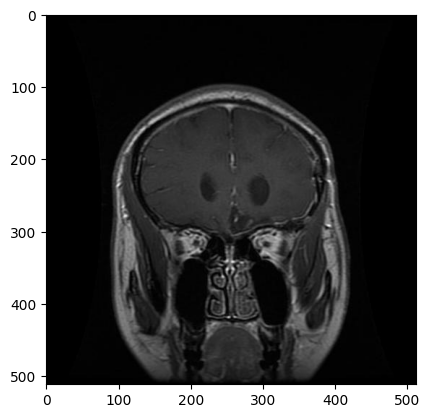

In [33]:
img = plt.imread('/content/glioma.jpg') #sample image downloaded externally
plt.imshow(img)

def prepare_img (image):
  IMG_SIZE = 224
  img_array = cv2.imread('/content/glioma.jpg', cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

img = cnn.predict([prepare_img('/content/glioma.jpg')])
print(img)

In [35]:
x= np.argmax(img)
print(classes[x])

Glioma


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[2.7937585e-02 9.7137982e-01 1.2493454e-04 5.5765157e-04]]


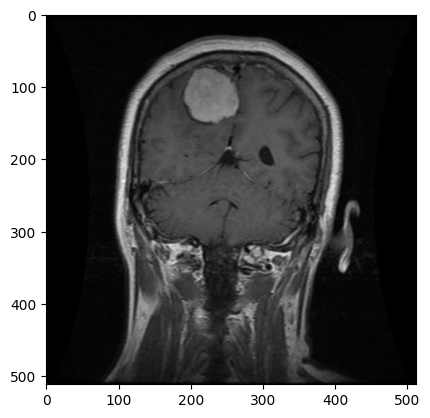

In [36]:
img = plt.imread('/content/meningioma.jpg') #sample image downloaded externally
plt.imshow(img)

def prepare_img (image):
  IMG_SIZE = 224
  img_array = cv2.imread('/content/meningioma.jpg', cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

img = cnn.predict([prepare_img('/content/meningioma.jpg')])
print(img)

In [38]:
x= np.argmax(img)
print(classes[x])

Meningioma


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[7.5539382e-04 5.9913807e-03 1.4524446e-04 9.9310791e-01]]


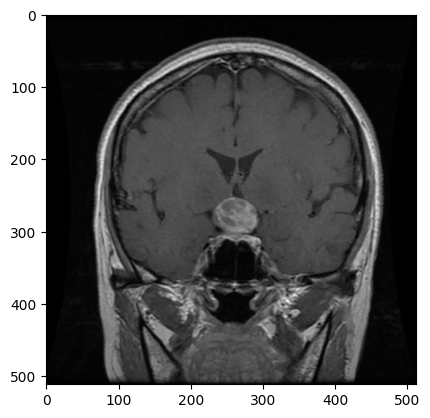

In [39]:
img = plt.imread('/content/pituitary.jpg') #sample image downloaded externally
plt.imshow(img)

def prepare_img (image):
  IMG_SIZE = 224
  img_array = cv2.imread('/content/pituitary.jpg', cv2.IMREAD_COLOR)
  new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
  return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

img = cnn.predict([prepare_img('/content/pituitary.jpg')])
print(img)

In [40]:
x= np.argmax(img)
print(classes[x])

Pituitary


**Model has given right predictions to the provided images.**
**Try to input types of images from the training data so that model can predict right answers**